In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier

### Import & Preprocessing

In [3]:
df = pd.read_csv("heart_disease_prediction.csv")
df = df.rename({'Heart Disease': 'Y'}, axis=1) 
df["Y"].replace({'Absence' : int(0), "Presence" : int(1)}, inplace=True, regex=True)
df.head(10)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Y
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7,0
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6,1
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7,1
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7,1
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7,1


In [4]:
print(df.shape)
y = df.values[:,-1].astype(int)
X = df.drop("Y", axis=1)

(270, 14)


### Feature selection & Feature Examination

In [17]:
scaler = MinMaxScaler()
df_norm = X
df_norm[list(X)] = scaler.fit_transform(df[list(X)])

In [7]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
X_new = rfe.fit_transform(df_norm, y)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

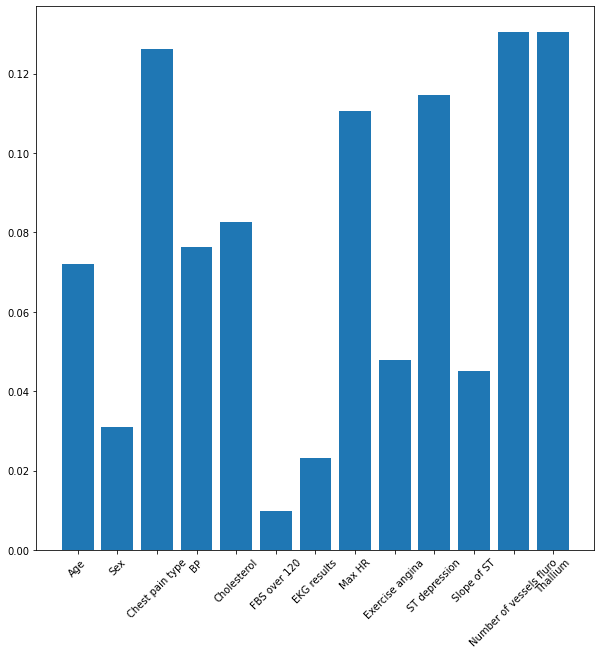

In [8]:
# Feature Selection Using Random Forest
clf = RandomForestClassifier()
clf.fit(df_norm, y)
# Create a figure to plot a bar, where x axis is features, and Y indicating the importance of each feature
plt.figure(figsize=(10,10))
plt.bar(df_norm.columns, clf.feature_importances_)
plt.xticks(rotation=45)

### Baseline Implementation & Model Training With all Features!!!

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	model.fit(X_train, y_train)
	return cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

models, names = list(), list()
# Dummy
models.append(DummyClassifier(strategy='most_frequent'))
names.append('DUM')
# SVM
models.append(SVC(gamma='auto'))
names.append('SVM')
# KNN
models.append(KNeighborsClassifier())
names.append('KNN')
# Bagging
models.append(BaggingClassifier(n_estimators=1000))
names.append('BAG')
# RF
models.append(RandomForestClassifier(n_estimators=1000))
names.append(' RF')
# ET
models.append(ExtraTreesClassifier(n_estimators=1000))
names.append(' ET')

results = list()
for i in range(len(models)):
	scores = evaluate_model(X_train, y_train, X_test, y_test, models[i])
	results.append(scores)
	print('>%s %.3f (%.3f)' % (names[i], scores.mean(), scores.std()))

>DUM 0.589 (0.022)
>SVM 0.810 (0.096)
>KNN 0.814 (0.119)
>BAG 0.755 (0.097)
> RF 0.774 (0.111)
> ET 0.775 (0.083)


In [ ]:
# Let's say we have 4 features: x1, x2, x3, x4
# 1. Function which returns all the possible combinations: E.g.: For 3 features: (x1, x2), (x2, x3), (x1, x3), (x1, x2, x3).
# 2. We Iterate through this list, and for each, we try to find the best oversampler (augmentation method) out of 5-10 oversamplers.
# 3. We run RandomForestClassifier and for each itertation, we save the rankings of the features based on importance.
# 3.2. Upon validation we take the same subsets of the validation set!
# 4. Write our own evaulation method: Take the rankings and select the top 3 features (and the best oversampler.)

In [29]:
import itertools
import random

feature_set = df_norm.columns
#Remove this line for proper results
feature_set = random.sample(list(feature_set), 4)
combinations = []
for L in range(2, len(feature_set) + 1):
    for subset in itertools.combinations(feature_set, L):
        combinations.append(subset)
        print(subset)
print(len(combinations))

('Age', 'ST depression')
('Age', 'Number of vessels fluro')
('Age', 'Exercise angina')
('ST depression', 'Number of vessels fluro')
('ST depression', 'Exercise angina')
('Number of vessels fluro', 'Exercise angina')
('Age', 'ST depression', 'Number of vessels fluro')
('Age', 'ST depression', 'Exercise angina')
('Age', 'Number of vessels fluro', 'Exercise angina')
('ST depression', 'Number of vessels fluro', 'Exercise angina')
('Age', 'ST depression', 'Number of vessels fluro', 'Exercise angina')
11
